In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
data = pd.read_csv('ES_1min_sample.csv')

#make sure the data is in the right format
data['timestamp'] = pd.to_datetime(data['timestamp'])


data.head()

timestamp     open     high      low   close  volume
0 2025-04-20 18:00:00  5283.75  5306.75  5279.00  5300.0    2472
1 2025-04-20 18:01:00  5299.75  5300.75  5294.00  5295.0     511
2 2025-04-20 18:02:00  5295.00  5296.25  5290.50  5295.0     544
3 2025-04-20 18:03:00  5295.25  5295.50  5291.25  5292.0     342
4 2025-04-20 18:04:00  5292.25  5294.25  5292.00  5292.5     284

In [4]:
def create_tick_bars(df, ticks_per_bar):
    bars = []
    for i in range(0, len(df), ticks_per_bar):
        bar = df.iloc[i:i + ticks_per_bar]
        # Add the timestamp of the last row as the bar's timestamp
        bar['bar_timestamp'] = bar.iloc[-1]['timestamp']
        bars.append(bar)
    return bars


def create_volume_bars(df, volume_per_bar):
    bars = []
    current_bar = []
    volume_acc = 0

    for _, row in df.iterrows():
        current_bar.append(row)
        volume_acc += row['volume']
        
        # When the volume accumulated exceeds the threshold, create a new bar
        if volume_acc >= volume_per_bar:
            # Set the timestamp to the last row's timestamp
            current_bar_df = pd.DataFrame(current_bar)
            current_bar_df['bar_timestamp'] = current_bar_df.iloc[-1]['timestamp']
            bars.append(current_bar_df)
            current_bar = []
            volume_acc = 0

    # Append any remaining rows that did not reach the volume threshold
    if current_bar:
        current_bar_df = pd.DataFrame(current_bar)
        current_bar_df['bar_timestamp'] = current_bar_df.iloc[-1]['timestamp']
        bars.append(current_bar_df)

    return bars

def create_dollar_bars(df, dollar_threshold):
    bars = []
    current_bar = []
    dollar_accumulated = 0
    last_price = None

    for _, row in df.iterrows():
        if last_price is not None:
            price_change = abs(row['close'] - last_price)
            dollar_change = price_change * row['volume']
        else:
            price_change = 0
            dollar_change = 0

        # Add the current row's volume and price movement to the dollar accumulation
        dollar_accumulated += dollar_change
        current_bar.append(row)

        # When the dollar accumulated exceeds the threshold, create a new bar
        if dollar_accumulated >= dollar_threshold:
            # Set the timestamp to the last row's timestamp
            current_bar_df = pd.DataFrame(current_bar)
            current_bar_df['bar_timestamp'] = current_bar_df.iloc[-1]['timestamp']
            bars.append(current_bar_df)
            current_bar = []
            dollar_accumulated = 0  # Reset for the next bar

        last_price = row['close']

    # Append any remaining rows that did not reach the dollar threshold
    if current_bar:
        current_bar_df = pd.DataFrame(current_bar)
        current_bar_df['bar_timestamp'] = current_bar_df.iloc[-1]['timestamp']
        bars.append(current_bar_df)

    return bars

In [5]:
# Assuming each bar now has a 'bar_timestamp' column
def count_bars_per_week(bars):
    # Combine all bars into a single DataFrame
    combined_bars = pd.concat(bars, ignore_index=True)
    
    # Set the 'bar_timestamp' as a datetime index for easier grouping
    combined_bars['week'] = combined_bars['bar_timestamp'].dt.to_period('W')  # 'W' for weekly frequency
    
    # Count the number of bars per week
    weekly_counts = combined_bars.groupby('week').size()
    return weekly_counts

In [10]:
def count_bars_per_day(bars):
    # Combine all bars into a single DataFrame
    combined_bars = pd.concat(bars, ignore_index=True)
    
    # Set the 'bar_timestamp' as a datetime index for easier grouping
    combined_bars['day'] = combined_bars['bar_timestamp'].dt.to_period('D')  # 'D' for daily frequency
    
    # Count the number of bars per day
    daily_counts = combined_bars.groupby('day').size()
    return daily_counts

In [38]:
tick_bars = create_tick_bars(data, 1)
volume_bars = create_volume_bars(data, 1000)
dollar_bars = create_dollar_bars(data, 10000)

C:\Users\HP\AppData\Local\Temp\ipykernel_4456\3155676393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar['bar_timestamp'] = bar.iloc[-1]['timestamp']
C:\Users\HP\AppData\Local\Temp\ipykernel_4456\3155676393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bar['bar_timestamp'] = bar.iloc[-1]['timestamp']
C:\Users\HP\AppData\Local\Temp\ipykernel_4456\3155676393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [39]:
tick_count_w = count_bars_per_week(tick_bars)
volume_count_W = count_bars_per_week(volume_bars)
dollar_count_W = count_bars_per_week(dollar_bars)

In [40]:
tick_count_d = count_bars_per_day(tick_bars)
volume_count_d = count_bars_per_day(volume_bars)
dollar_count_d = count_bars_per_day(dollar_bars)

In [41]:
count_df = pd.DataFrame({
    'Tick Bars': tick_count_d,
    'Volume Bars': volume_count_d,
    'Dollar Bars': dollar_count_d
})

<Axes: xlabel='day'>

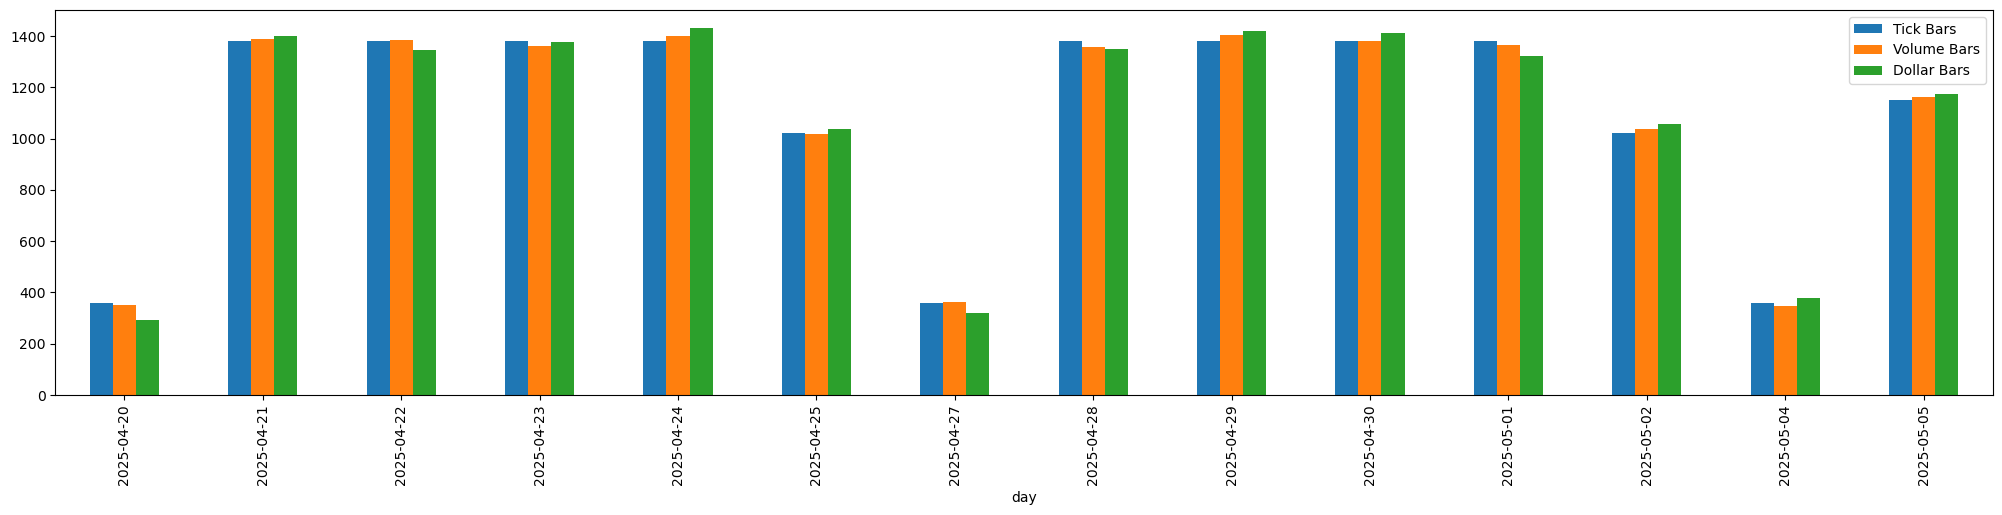

In [42]:
count_df.loc[:, ['Tick Bars', 'Volume Bars', 'Dollar Bars']].plot(kind = 'bar', figsize=[25, 5])

In [43]:

print(count_df['Dollar Bars'].autocorr())
print(count_df['Volume Bars'].autocorr())
print(count_df['Tick Bars'].autocorr())


0.023629135965086676
0.045553753527043626
0.05049881747289781
